In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf

**SELECTING AND DOWNLOADING INDIAN STOCKS..**

In [161]:
tickers=["RELIANCE.NS","IBN","INFY"]
data= yf.download(tickers,start='2020-01-01',end='2025-06-01',interval="1mo")
data=data["Close"]
data = data.rename(columns={ticker: f'{ticker}_Close' for ticker in tickers})
data = data.dropna()
data

[*********************100%***********************]  3 of 3 completed


Ticker,IBN_Close,INFY_Close,RELIANCE.NS_Close
Date,,,
2020-01-01,14.210198,9.686424,638.397888
2020-02-01,13.518207,8.899844,600.862366
2020-03-01,8.284409,7.255980,503.677063
2020-04-01,9.512452,8.157454,662.976929
2020-05-01,8.479337,8.042561,668.530823
...,...,...,...
2025-01-01,28.670000,21.950001,1265.099976
2025-02-01,27.879999,20.100000,1200.099976
2025-03-01,31.520000,18.250000,1275.099976


**COMPUTING KEY METRICS..**

In [162]:
## monthly data
returns=data.pct_change().dropna()
avg_returns=returns.mean()
std_returns=returns.std()
covariance=returns.cov()
summary=pd.DataFrame({
    "Expected returns":avg_returns,
    "Volatility":std_returns
})
print(summary,"\n")
covariance

                   Expected returns  Volatility
Ticker                                         
IBN_Close                  0.017984    0.087703
INFY_Close                 0.013625    0.088095
RELIANCE.NS_Close          0.015520    0.079475 



Ticker,IBN_Close,INFY_Close,RELIANCE.NS_Close
Ticker,,,
IBN_Close,0.007692,0.002349,0.002812
INFY_Close,0.002349,0.007761,0.003018
RELIANCE.NS_Close,0.002812,0.003018,0.006316


**CREATING PORTFOLIO WITH RANDOM WEIGHTS**

In [163]:
portfolios=2000
all_returns=[]
all_std=[]
all_sharpes=[]

i=0
while i<portfolios:
  weights=np.random.rand(len(tickers))
  norm_weights= weights/weights.sum()

  port_returns=np.dot(norm_weights,avg_returns)
  all_returns.append(port_returns)

  port_std=np.sqrt(np.dot(norm_weights.T, np.dot(covariance,norm_weights)))
  all_std.append(port_std)

  sharpe=(port_returns-0.005)/port_std
  all_sharpes.append(sharpe)
  i+=1


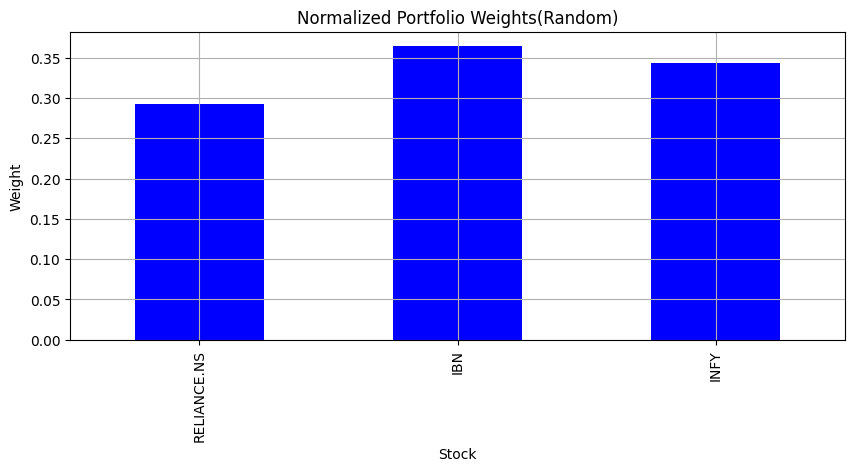

In [164]:
plt.figure(figsize=(10, 4))
pd.Series(norm_weights, index=tickers).plot(kind='bar', color='blue')
plt.title('Normalized Portfolio Weights(Random)')
plt.ylabel('Weight')
plt.xlabel('Stock')
plt.grid(True)
plt.show()

**FETCHING INDEX OF MAX SHARPE AND MIN STD**

In [165]:
max_sharpe_idx=np.argmax(all_sharpes)
min_vol_idx=np.argmin(all_std)

**FOR CONSTRUCTING THE EFFICIENT FRONTIER**

In [166]:
df = pd.DataFrame({
    'Return': all_returns,
    'Risk': all_std,
    'Sharpe': sharpe
})
sorted_df = df.sort_values('Risk')
efficient_portfolios = []
max_return = -np.inf

for _, row in sorted_df.iterrows():
    if row['Return'] > max_return:
        efficient_portfolios.append(row)
        max_return = row['Return']
efficient_frontier = pd.DataFrame(efficient_portfolios)


**USING SLOPE METHOD TO CONSTRUCT CAPITAL MARKET LINE**

In [167]:
risk_free_rate = 0.005  # Given

x = df.loc[max_sharpe_idx, 'Risk']
y = df.loc[max_sharpe_idx, 'Return']
slope = (y - risk_free_rate) / x

x_vals = np.linspace(0, df['Risk'].max(), 100)
y_vals = risk_free_rate + slope * x_vals

**PLOTTING ALL THE ESSENTIALS**

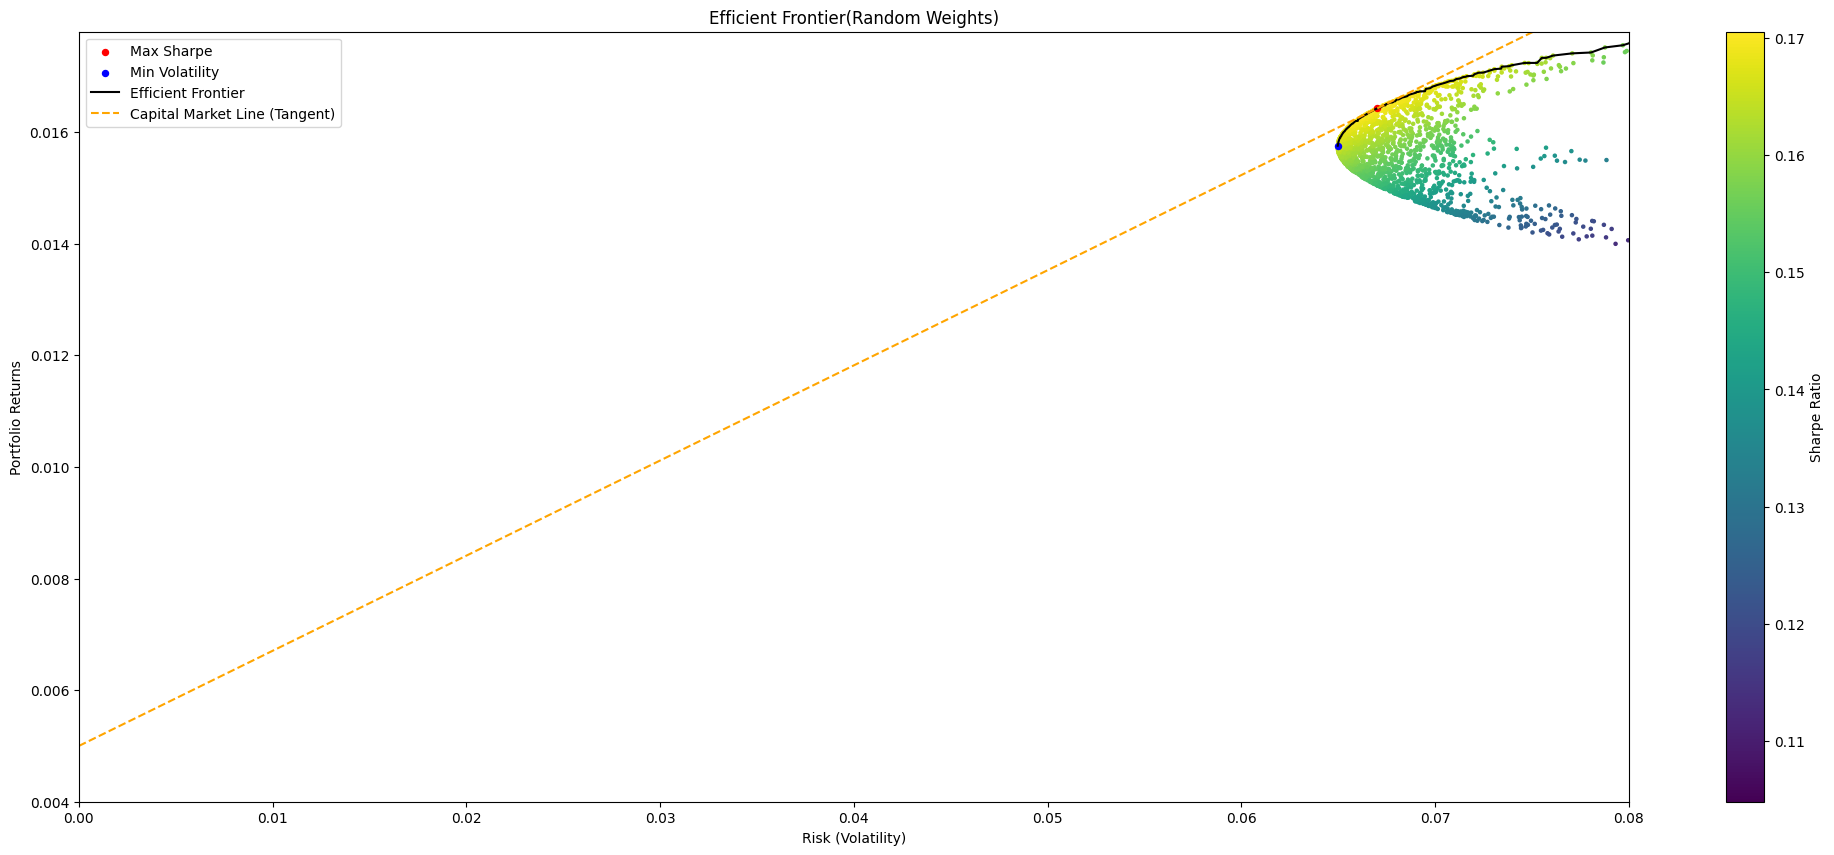

In [168]:
plt.figure(figsize=(25, 10))
plt.scatter(all_std, all_returns,c=all_sharpes,cmap='viridis',s=5,alpha=1)  ##Scatter
plt.colorbar(label='Sharpe Ratio')
plt.scatter(all_std[max_sharpe_idx], all_returns[max_sharpe_idx], color='r', marker='.', s=75, label='Max Sharpe')
plt.scatter(all_std[min_vol_idx], all_returns[min_vol_idx], color='b', marker='.', s=75, label='Min Volatility')

plt.plot(efficient_frontier['Risk'], efficient_frontier['Return'], color='black', lw=1.5, label='Efficient Frontier') ##frontier

plt.plot(x_vals, y_vals, '--', color='orange', label='Capital Market Line (Tangent)') ##tangent
plt.xlim(0.0, 0.08)
plt.ylim(0.004, 0.0178)

plt.xlabel('Risk (Volatility)')
plt.ylabel('Portfolio Returns')
plt.title('Efficient Frontier(Random Weights)')
plt.legend()
plt.show()